Average iterative kNN time for 10 iterations: 8.771801 seconds
Average vectorized kNN time for 10 iterations: 0.429688 seconds
Average scikit-learn kNN time for 10 iterations: 0.045279 seconds

Vectorized kNN was faster than iterative kNN by: 95.10%
Scikit-learn kNN was faster than vectorized kNN by: 89.46%

The accuracy for the itterarive kNN model was 53.98724082934609 %
The accuracy for the vector kNN model was 53.42902711323764 %
The Accuracy for the scikit-learn kNN model: 53.42902711323764%


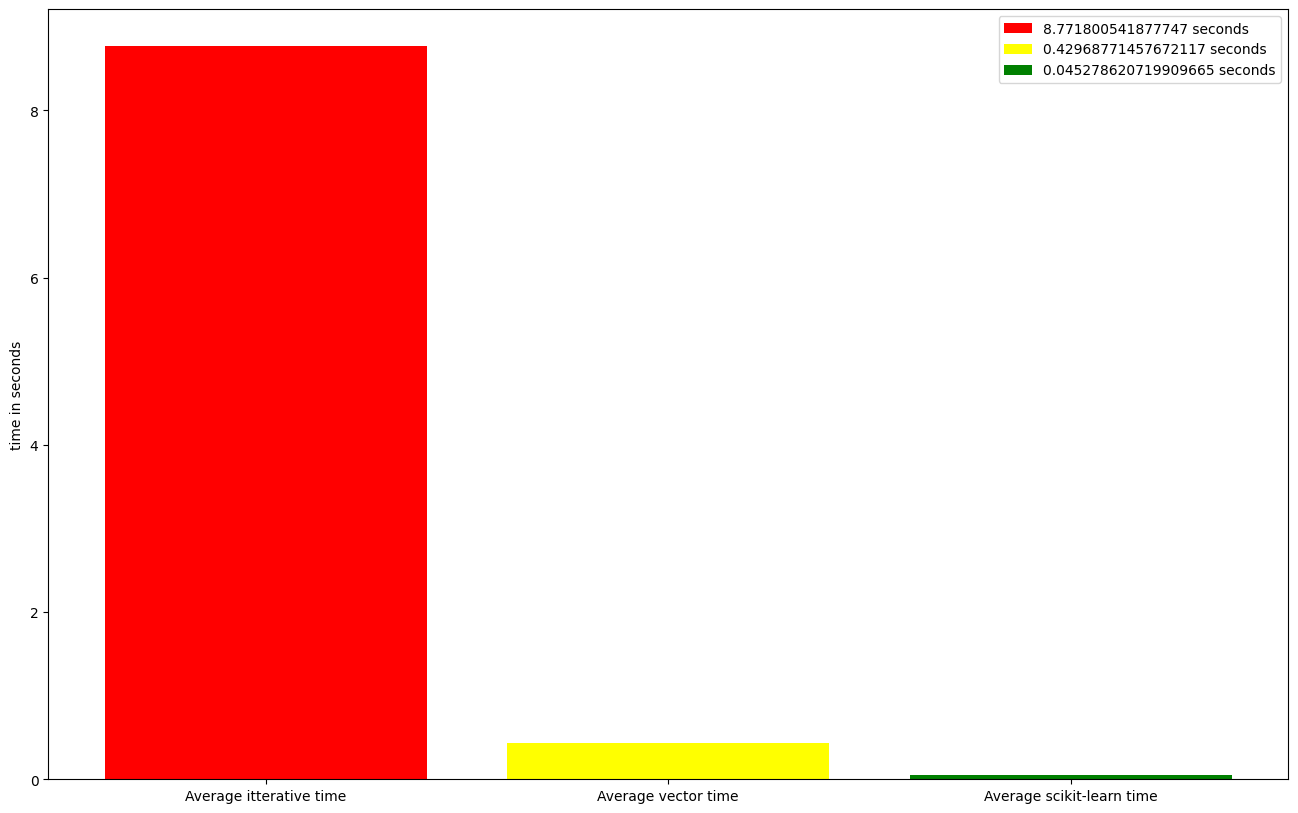

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

"""---------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------"""

class KNN_iterative:
    def __init__(self, k= 5):
        self.k = k

    def get_distance (self, point_1, point_2):
        distance = 0
        for val1, val2 in zip(point_1, point_2):
            distance += (val1 - val2) ** 2
        return distance ** 0.5

    def predict(self, X_test, X_train, y_train):
        distances = []
        k_smallest_indices = []
        predictions = []

        # Compute all the distances for every point in the test array and append to distances list
        for data_point in X_test:
            current_point = []
            for train_point in X_train:
                current_point.append(self.get_distance(data_point, train_point))
            distances.append(current_point)

        for values in distances:
            arg_sorted_indices = sorted(range(len(values)), key=lambda k: values[k])  #The key parameter allows us to specify a custom way of sorting, in this case, a lambda function. 
            # In this lambda function, we take an index, 'k' as input and return a the value of that index. This makes the sorted() function compare the values of the indexes and not the indexes themselves, to later return a list of the sorted indexes.
            k_smallest_indices.append(arg_sorted_indices[:self.k])

        for indices in k_smallest_indices:
            label_votes = {}  #Dictionary to store votes for each label

            for i in indices:
                label = y_train[i]

                # Update the vote count for the label
                if label in label_votes:
                    label_votes[label] += 1
                else:
                    label_votes[label] = 1

            # Find the label with the maximum vote count
            majority_vote = max(label_votes, key=label_votes.get)      #.get returns the value of the key if the given key is in the dictionary
            predictions.append(majority_vote)

        return predictions
        #fetch the lables of the k smallest distances for every point and do majority voting

    def test_accuracy(self, predicted_labels, true_labels):
        accuracy_count = 0
        for pred, true in zip(predicted_labels, true_labels):
            if pred == true:
                accuracy_count += 1
        accuracy_percentage = (accuracy_count / len(true_labels)) * 100
        return accuracy_percentage

"""---------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------"""

class KNN_numpy:
    def __init__(self, k=5):
        self.k = k

    def predict(self, X_test, X_train, y_train):
        self.X_test = X_test
        self.X_train = X_train
        self.y_train = y_train
        predictions = []
        
        #Reshaping the data to do the broadcasting 
        self.X_train_reshaped = self.X_train[np.newaxis, :, :]  #Broadcasting only works on 2D arrays when they either are equal or one of the two dimensions are equal to one
        self.X_test_reshaped = self.X_test[:, np.newaxis, :]    #To be able to broadcast, we add a third dimension to each 2D array. This will ensure that we meet the crieteria.
        #Arrays must have the same number of dimensions, and the length of each dimension is either a common length or 1. By reshaping it into this shape, we make the different shapes compatible.

        #Finding all distances with broadcasting
        squared_diff = (self.X_test_reshaped - self.X_train_reshaped)**2
        sum_squared_diff = np.sum(squared_diff, axis=2)     #the axis keyword specifies along which axis the summation is going to happen
        distance = sum_squared_diff**0.5

        k_smallest_indices = np.argsort(distance)[:, :self.k]   #Argsort performs an indirect sorting along an axis and returns an array of sorted indices. In this case we have indexed it to only take and return the k smallest values

        predictions = []
        for indices in k_smallest_indices:
            # Use the corresponding labels for the indices
            labels = self.y_train[indices]

            # Find the most frequent label
            unique_labels, counts = np.unique(labels, return_counts=True)   #numpy function to find the unique elements of an array. This one also return the counts of each unique element which is stored into
            most_frequent_index = np.argmax(counts)     #Numpy function to return the indices of the maximum values along an axis.
            most_frequent_label = unique_labels[most_frequent_index]
            predictions.append(most_frequent_label)
        
        self.predicted_labels = predictions

        return predictions

    def test_accuracy(self, predicted_labels, true_labels):
        accuracy_count = 0
        for pred, true in zip(predicted_labels, true_labels):
            if pred == true:
                accuracy_count += 1
        accuracy_percentage = (accuracy_count / len(true_labels)) * 100
        return accuracy_percentage

"""---------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------"""

class KNNBenchmark:
    def __init__(self, k=5):
            self.k = k
            self.knn_iterative = KNN_iterative(k)
            self.knn_numpy = KNN_numpy(k)
            self.reference_model = KNeighborsClassifier(n_neighbors=k)

    def test_accuracy(self, predicted_labels, true_labels):
        accuracy_count = 0
        for pred, true in zip(predicted_labels, true_labels):
            if pred == true:
                accuracy_count += 1
        accuracy_percentage = (accuracy_count / len(true_labels)) * 100
        return accuracy_percentage

    def benchmark(self, X_train_list, X_test_list, y_train_list, y_test_list, X_train_array, X_test_array, y_train_array, y_test_array, num_iterations=1):
        
        # Benchmark iterative KNN
        iterative_total_time = 0
        for _ in range(num_iterations):
            start_time = time.time()
            predicted_itterative = self.knn_iterative.predict(X_test_list, X_train_list, y_train_list)
            iterative_total_time += time.time() - start_time
        avg_itterative_time = iterative_total_time / num_iterations

        # Benchmark vectorized KNN
        vectorized_total_time = 0
        for _ in range(num_iterations):
            start_time = time.time()
            predicted_vectorized= self.knn_numpy.predict(X_test_array, X_train_array, y_train_array)
            vectorized_total_time += time.time() - start_time
        avg_vectorized_time = vectorized_total_time / num_iterations

        # Benchmark scikit-learn kNN
        self.reference_model.fit(X_train_array, y_train_array)
        reference_model_total_time = 0
        for _ in range(num_iterations):
            start_time = time.time()
            y_predicted = self.reference_model.predict(X_test_array)
            reference_model_total_time += time.time() - start_time
        avg_reference_time = reference_model_total_time / num_iterations

        percentage_improvement_vector = ((avg_itterative_time - avg_vectorized_time) / avg_itterative_time) * 100
        percentage_improvement_scikit = ((avg_vectorized_time - avg_reference_time) / avg_vectorized_time) * 100

        print(f"Average iterative kNN time for {num_iterations} iterations: {avg_itterative_time:.6f} seconds")
        print(f"Average vectorized kNN time for {num_iterations} iterations: {avg_vectorized_time:.6f} seconds")
        print(f"Average scikit-learn kNN time for {num_iterations} iterations: {avg_reference_time:.6f} seconds")
        print()
        print(f"Vectorized kNN was faster than iterative kNN by: {percentage_improvement_vector:.2f}%")
        print(f"Scikit-learn kNN was faster than vectorized kNN by: {percentage_improvement_scikit:.2f}%")
        print()
        print(f"The accuracy for the itterarive kNN model was {self.test_accuracy(predicted_itterative, y_test_list)} %")
        print(f"The accuracy for the vector kNN model was {self.test_accuracy(predicted_vectorized, y_test_array)} %")
        print(f"The Accuracy for the scikit-learn kNN model: {self.test_accuracy(y_predicted, y_test_array)}%")

        return avg_itterative_time, avg_vectorized_time, avg_reference_time

"""---------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------"""

class Plot_benchamrk_times:
    def __init__(self, avg_itterative_time, avg_vectorized_time, avg_reference_time):
        self.avg_itterative_time = avg_itterative_time
        self.avg_vectorized_time = avg_vectorized_time
        self.avg_reference_time = avg_reference_time
        self.avg_itterative_time_label = "Average itterative time"
        self.avg_vectorized_time_label = "Average vector time"
        self.avg_reference_time_label = "Average scikit-learn time"

    def display_results(self):
        plt.figure(figsize=(16,10))
        plt.bar(self.avg_itterative_time_label, self.avg_itterative_time, color="red", label=f"{self.avg_itterative_time} seconds")
        plt.bar(self.avg_vectorized_time_label, self.avg_vectorized_time, color="yellow", label=f"{self.avg_vectorized_time} seconds")
        plt.bar(self.avg_reference_time_label, self.avg_reference_time, color="green", label=f"{self.avg_reference_time} seconds")
        plt.ylabel("time in seconds")
        plt.legend()
        plt.show()

"""---------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------"""

#Readnig the data from the abalone dataset
abalone_train_df = pd.read_csv(r"abalone.csv")
X_abalone = abalone_train_df.drop("a", axis=1)  # Replace 'target_column_name' with your actual target column
y_abalone = abalone_train_df["a"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_abalone, y_abalone, test_size=0.3, random_state=42)

#lists
X_train_abalone_list = X_train.values.tolist()
X_test_abalone_list = X_test.values.tolist()
y_train_abalone_list = y_train.values.tolist()
y_test_abalone_list = y_test.values.tolist()

#numpy arrays
X_train_abalone_array = np.array(X_train_abalone_list)
X_test_abalone_array = np.array(X_test_abalone_list)
y_train_abalone_array = np.array(y_train_abalone_list)
y_test_abalone_array = np.array(y_test_abalone_list)

"""---------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------"""

#Running a benchmark on both models to evaluate speed and accuracy over the different models
benchmark_abalone = KNNBenchmark()
avg_itterative_time, avg_vectorized_time, avg_reference_time = benchmark_abalone.benchmark(X_train_abalone_list, X_test_abalone_list, y_train_abalone_list, y_test_abalone_list, 
                                                                                           X_train_abalone_array, X_test_abalone_array, y_train_abalone_array,y_test_abalone_array, num_iterations=10)

"""---------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------"""

#Plotting the results
visualization = Plot_benchamrk_times(avg_itterative_time, avg_vectorized_time, avg_reference_time)
visualization.display_results()
